# Post Classifier for Jokes and Horror stories

Goal: To train a classifier to filter out horror stories from the jokes thread based on the title and content of the post

In [1]:
#installing of wordcloud. 
#pip install wordcloud

In [2]:
import requests
import time
import pandas as pd
import regex as re
import numpy as np

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# Importing Jokes

In [3]:
#CSV importing 
df1 = pd.read_csv('jokes.csv')

In [4]:
df1.columns

Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
       'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
       ...
       'permalink', 'parent_whitelist_status', 'stickied', 'url',
       'subreddit_subscribers', 'created_utc', 'num_crossposts', 'media',
       'is_video', 'author_cakeday'],
      dtype='object', length=101)

In [5]:
#brief check for format and shape
print(df1.shape)
df1 = df1[['title','selftext','subreddit']]
df1.head()

(1486, 101)


,title,selftext,subreddit
0,r/jokes has a discord and you need to join!,Over 10k members! Come see reposts in real ti...,Jokes
1,If big feet means big dick and big car means s...,Then no wonder people are so scared of clowns.,Jokes
2,"When I was younger, the local priest told me t...",I was touched.,Jokes
3,"“Judge, 60% of my parking tickets are bogus!”",Judge: Repeat infractions?\n\nMan: Fine. 3/5 o...,Jokes
4,What's the definition of a reverse exorcism?,It's when you ask the Devil to get the priest ...,Jokes


In [6]:
#checking for unique links and duplicates
df1.selftext.value_counts()

The second time let me down.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     3
Really vintage stuff. I’m glad I found it though, I had forgotten how blonde my hair used to be.                                                                                                                                                                                                                                                                                     

In [7]:
#check for duplicate rows
duplicaterows = df1[df1.duplicated(['selftext','title'],keep='first')]
duplicaterows.shape

(601, 3)

In [8]:
#checking the duplicate rows
pd.set_option("display.max_columns", 107)
df1.sort_values(by=['title']).head(4)

,title,selftext,subreddit
1398,"""Bam! Kapow! Smash! Punch!""",**Batman:** those are fighting words,Jokes
511,"""Bam! Kapow! Smash! Punch!""",**Batman:** those are fighting words,Jokes
53,"""Darling, I have to tell you something""","A husband says to his wife: ""Darling, I have t...",Jokes
938,"""Darling, I have to tell you something""","A husband says to his wife: ""Darling, I have t...",Jokes


In [9]:
#dropping duplicate rows
df1.drop_duplicates(['selftext','title'],keep='first',inplace=True)

# Importing No Sleep

In [10]:
#CSV importing 
df2 = pd.read_csv('nosleep.csv')
df2 = df2[['title','selftext','subreddit']]
df2.head()

,title,selftext,subreddit
0,December 2019 Voting Thread,NaN,nosleep
1,2020 Nosleep Community Survey,NaN,nosleep
2,"Someone keeps leaving gifts at my doorstep, an...","I live by myself, on the first floor of a very...",nosleep
3,The Inheritance Game - What exactly would you ...,[Part 1](https://www.reddit.com/r/nosleep/comm...,nosleep
4,"I Lost My Virginity to My Girlfriend, It Turne...",Parts: [1](https://www.reddit.com/r/nosleep/co...,nosleep


In [11]:
#check for duplicate rows
duplicaterows_2 = df2[df2.duplicated(['selftext','title'],keep='first')]
duplicaterows_2.shape

(676, 3)

In [12]:
#dropping duplicate rows
df2.drop_duplicates(['selftext','title'],keep='first',inplace=True)
df2.shape

(805, 3)

In [13]:
#finding the number of null values
df1[['selftext','title']].isnull().sum()

selftext    0
title       0
dtype: int64

In [14]:
#finding the number of null values
df2[['selftext','title']].isnull().sum()

selftext    2
title       0
dtype: int64

In [15]:
#dropping nulls and combining to a single DataFrame
df1.dropna(axis=0,inplace=True)
df2.dropna(axis=0,inplace=True)
comb_df = pd.concat([df1,df2])

In [16]:
#making the target variable the horror stories.
comb_df = pd.get_dummies(comb_df,columns = ['subreddit'],drop_first=True)


In [17]:
#Displaying final Dataframe for modelling
comb_df['text_features']= comb_df['title']+comb_df['selftext']
comb_df

,title,selftext,subreddit_nosleep,text_features
0,r/jokes has a discord and you need to join!,Over 10k members! Come see reposts in real ti...,0,r/jokes has a discord and you need to join!Ove...
1,If big feet means big dick and big car means s...,Then no wonder people are so scared of clowns.,0,If big feet means big dick and big car means s...
2,"When I was younger, the local priest told me t...",I was touched.,0,"When I was younger, the local priest told me t..."
3,"“Judge, 60% of my parking tickets are bogus!”",Judge: Repeat infractions?\n\nMan: Fine. 3/5 o...,0,"“Judge, 60% of my parking tickets are bogus!”J..."
4,What's the definition of a reverse exorcism?,It's when you ask the Devil to get the priest ...,0,What's the definition of a reverse exorcism?It...
...,...,...,...,...
800,"If you think I'm a terrible father, I don't bl...","Earlier today, I was in a rocking chair in my ...",1,"If you think I'm a terrible father, I don't bl..."
801,Stairway to Heaven,"I am scared. I am cold, I am wet, and I am sur...",1,"Stairway to HeavenI am scared. I am cold, I am..."
802,"Always watch out on the night of January 5th, ...","The night of January 5th is known as the ""Twel...",1,"Always watch out on the night of January 5th, ..."
803,I found an old book full of modern fairytales....,"[\#2 is up now: Kelpie, or Why You Should Neve...",1,I found an old book full of modern fairytales....


In [18]:
#checking the baseline score
comb_df['subreddit_nosleep'].value_counts(normalize=True)

0    0.524289
1    0.475711
Name: subreddit_nosleep, dtype: float64

In [19]:
#creating a list of stopwords unique to either subreddit
stop_words = text.ENGLISH_STOP_WORDS.union(['www','nosleep'])

In [20]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

# Creation of X and y and splitting the training and testing data

In [21]:
X = comb_df['text_features']
y = comb_df['subreddit_nosleep']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,random_state=7)

# WORDCLOUD

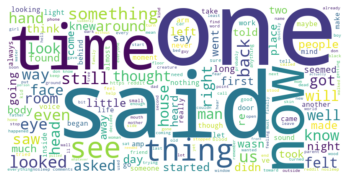

In [22]:
#creating the WordCloud of words that appears frequently in nosleep posts
text = " ".join(review for review in comb_df.loc[comb_df['subreddit_nosleep']==1]['text_features'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white",regexp=r"[a-zA-Z]{2,}",width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

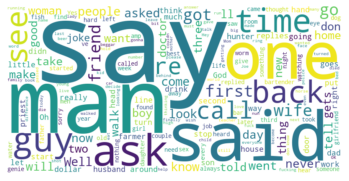

In [23]:
#creating the WordCloud of words that appears frequently in joke posts
text = " ".join(review for review in comb_df.loc[comb_df['subreddit_nosleep']==0]['text_features'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white",regexp=r"[a-zA-Z]{2,}",width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Logistic Regression (Count Vectoriser)

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipe_lr = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('lr',LogisticRegression(random_state=7,solver = 'liblinear'))])
grid_lr = GridSearchCV(pipe_lr,param_grid = {
    'cvec__max_features':[500,750,1000,1250],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)]
},verbose = 1,cv=3,n_jobs=1)

grid_lr.fit(X_train,y_train)
grid_lr.score(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.2min finished


1.0

In [25]:
#best parameters and scores
print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'cvec__max_df': 0.9, 'cvec__max_features': 1250, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
0.9968404423380727


In [26]:
#modelling based on the best parameters
best_pipe_lr = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',max_features=1250,ngram_range=(1,1),min_df=2,max_df=0.9,stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('lr',LogisticRegression(solver = 'liblinear'))])
best_pipe_lr.fit(X_train,y_train)
best_pipe_lr.score(X_train,y_train)

1.0

Logistic Regression (Count Vectoriser) score

In [27]:
lr_cvec_best = best_pipe_lr.score(X_test,y_test)
lr_cvec_best

0.995260663507109

In [28]:
#Logistic Regression (Count Vectoriser) confusion matrix
yhat_lr = best_pipe_lr.predict(X_test)
confusion_matrix(y_test, yhat_lr)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_lr).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 220
False Positives: 1
False Negatives: 1
True Positives: 200


# Bayes Classifier (Count Vectorizer)

In [29]:
nb_lr = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('nb',MultinomialNB())])

grid_nb = GridSearchCV(nb_lr,param_grid = {
    'cvec__max_features':[500,750,1000,1250],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)]
},cv=3,verbose=1,n_jobs=1)
grid_nb.fit(X_train, y_train)
grid_nb.score(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.2min finished


0.8996840442338072

In [30]:
#best parameters and scores
print(grid_nb.best_params_)
print(grid_nb.best_score_)

{'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3)}
0.8467614533965245


In [31]:
best_pipe_nb = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',max_features=500,ngram_range=(1,3),min_df=3,max_df=0.9,stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('nb',MultinomialNB())])
best_pipe_nb.fit(X_train,y_train)
best_pipe_nb.score(X_train,y_train)

0.8996840442338072

Bayes Classifier (Count Vectorizer) score

In [32]:
nb_cvec_best = best_pipe_nb.score(X_test,y_test)
nb_cvec_best

0.8957345971563981

In [33]:
yhat_nb = best_pipe_nb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_nb).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 179
False Positives: 42
False Negatives: 2
True Positives: 199


# Logistic Regression (TF-IDF)

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tfidf_lr = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('lr',LogisticRegression(random_state=7))])
grid_lrt = GridSearchCV(tfidf_lr,param_grid = {
    'tvec__max_features':[500,750,1000,1250],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)]
},verbose = 1,cv=3,n_jobs=1)

In [35]:
grid_lrt.fit(X_train,y_train)
grid_lrt.score(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.2min finished


0.9960505529225908

In [36]:
print(grid_lrt.best_params_)
print(grid_lrt.best_score_)

{'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
0.9960505529225908


In [37]:
best_lrt = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',max_df=0.9,max_features=500,min_df=2,ngram_range=(1,1),stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),\
                           ('lr',LogisticRegression(random_state=7))])
best_lrt.fit(X_train,y_train)
best_lrt.score(X_train,y_train)

0.9960505529225908

Logistic Regression (TF-IDF) score

In [38]:
lr_tfidf_best = best_lrt.score(X_test,y_test)
lr_tfidf_best 

0.995260663507109

In [39]:
lrt_predictions = pd.DataFrame(best_lrt.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, lrt_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 220
False Positives: 1
False Negatives: 1
True Positives: 200


# Bayes Classfier (TF-IDF)

In [40]:
tfidf_nb = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('nb',MultinomialNB())])
grid_nbt = GridSearchCV(tfidf_nb,param_grid = {
    'tvec__max_features':[500,750,1000,1250],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)]
},cv=3,verbose=1,n_jobs=1)

In [41]:
grid_nbt.fit(X_train,y_train)
grid_nbt.score(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.3min finished


0.9352290679304898

In [42]:
print(grid_nbt.best_params_)
print(grid_nbt.best_score_)

{'tvec__max_df': 0.9, 'tvec__max_features': 750, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
0.8688783570300158


In [43]:
best_nbt = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',max_features=750,ngram_range=(1,3),max_df=0.9,min_df=2,token_pattern=r"[a-zA-Z]{2,}",stop_words=stop_words)),\
                             ('nb',MultinomialNB())])
best_nbt.fit(X_train,y_train)
best_nbt.score(X_train,y_train)

0.9375987361769352

Bayes Classfier (TF-IDF) score

In [44]:
nb_tfidf_best = best_nbt.score(X_test,y_test)
nb_tfidf_best

0.9004739336492891

In [45]:
nbt_predictions = best_nbt.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, nbt_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 184
False Positives: 37
False Negatives: 5
True Positives: 196


# Choosing the model with the best score 

In [46]:
#displaying the best scores from each model
lr_cvec_best,nb_cvec_best,lr_tfidf_best,nb_tfidf_best

(0.995260663507109, 0.8957345971563981, 0.995260663507109, 0.9004739336492891)

| Model                                       | Score   |   |   |
|---------------------------------------------|---------|---|---|
| Logistic Regression \(Count Vectoriser\)    | 0\.9953 |   |   |
| Logistic Regression \(TF\-IDF\)             | 0\.9976 |   |   |
| Multinomial Classifier \(Count Vectoriser\) | 0\.8957 |   |   |
| Multinomial Classifier \(TF\-IDF\)          | 0\.9004 |   |   |



In [47]:
#creating a table with to show the strongest coefficients from the best model
lr_coefs = pd.DataFrame(best_lrt.steps[1][1].coef_,columns = best_lrt.steps[0][1].get_feature_names()).T.sort_values(by = 0, ascending = False)
lr_coefs

,0
amp,2.129131
like,2.056029
time,1.894664
eyes,1.818510
didn,1.752185
...,...
does,-0.114307
son,-0.135079
guy,-0.233861
wife,-0.477917


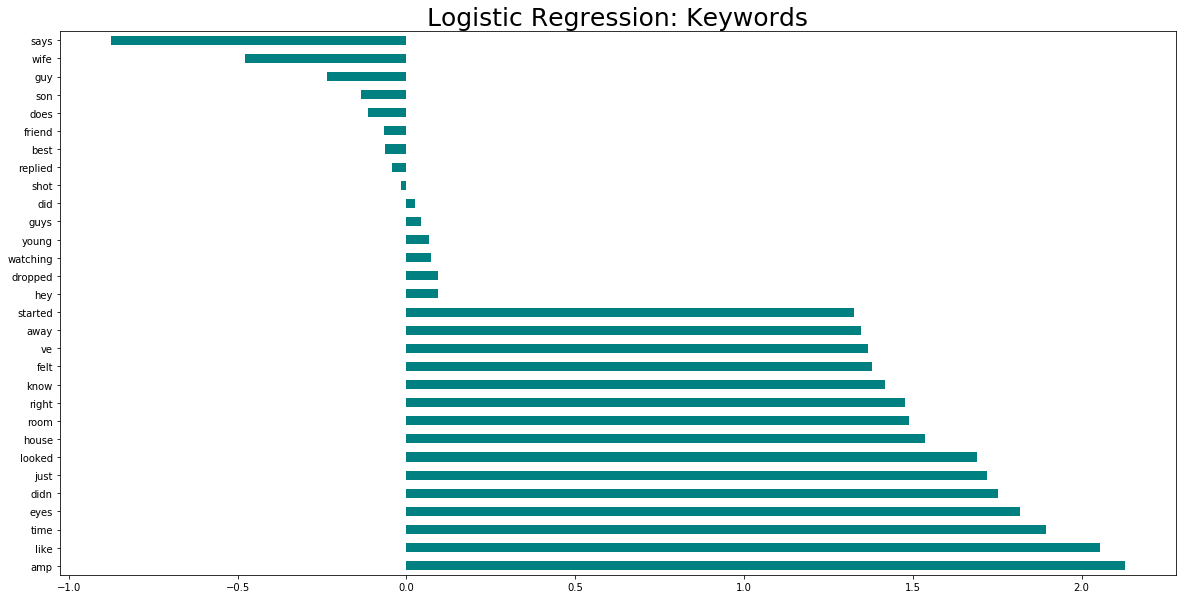

In [48]:
#displaying the strongest 15 coefficients and their associated words
top_coef = pd.concat([lr_coefs.head(15),
                      lr_coefs.tail(15)])
plt.rcParams['figure.figsize'] = (20.0, 10.0)
top_coef.plot(kind = "barh", legend = False,color='teal')
plt.title('Logistic Regression: Keywords',size = 25)
plt.xlabel('Coefficients')
plt.ylabel('token')
plt.show()